## Objective

We create a portfolio of stocks from American markets, analyze their performance and try to acess the risk in future.


### Building the porfolio

We will build a tech dominant portfolio to analyze including companies like Apple, Microsoft, Google etc.



In [70]:
import yfinance as yf
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np 
from ipywidgets import interact
import pandas as pd 

output_mf = widgets.Output()

# List of stock symbols
tech_stocks = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'NVDA', 'INTC', 'ADBE', 'NFLX']

# Set the date range for the historical data
start_date = '2022-08-01'
end_date = '2023-08-01'

# Download historical stock data for each stock

all_data = yf.download(tech_stocks, start_date, end_date)

Tech_data = all_data['Adj Close']


[*********************100%%**********************]  10 of 10 completed


In [72]:

# Lets take the weights of individual stocks to be
# equal weights
weights = [1.0/len(tech_stocks) for i in range(len(tech_stocks))]

# get daily returns for each stock

daily_return = Tech_data.pct_change()



### Testing for normality 

The Jarque-bera test can be used to compare the skewness and kurtosis of both data sets against that of the normal distribution. In contrast the KS test and Anderson-Darling tests can be used to compare the goodness of fit of the data to the normal distribution.

We start with first the visualisation

<Axes: xlabel='Date'>

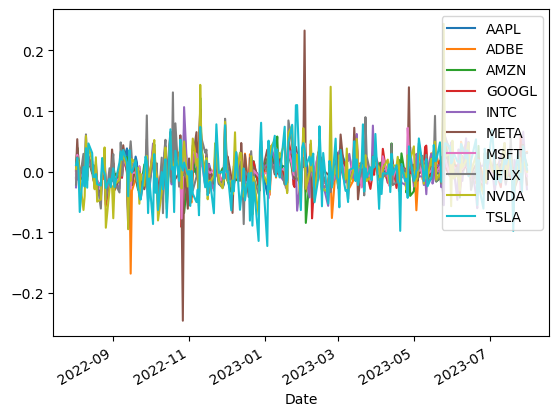

In [73]:
daily_return.plot()

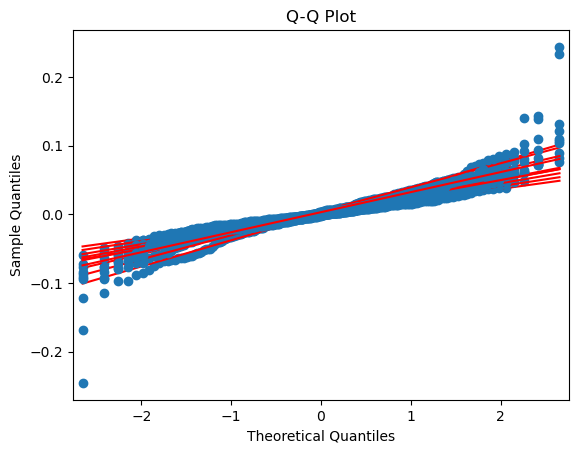

In [74]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1)
ax.set_xlabel(r'Returns')
ax.set_ylabel(r'Probability')

for stock in tech_stocks:
    # Q-Q Plot
    returns = daily_return[stock][1:]
    sm.qqplot(returns, line="r", ax=ax)
    ax.set_title("Q-Q Plot")


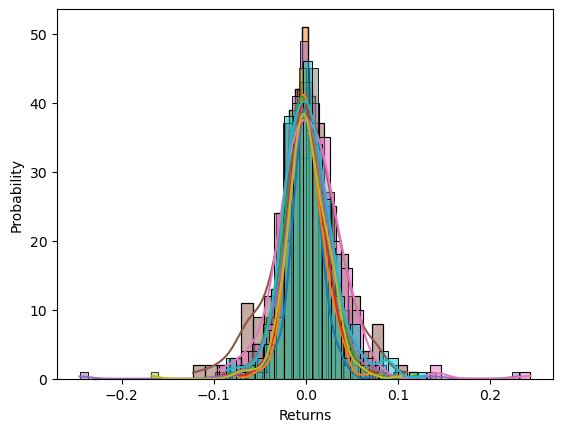

In [75]:
import seaborn as sns
fig,ax = plt.subplots(1,1)
ax.set_xlabel(r'Returns')
ax.set_ylabel(r'Probability')
for stock in tech_stocks:
    returns = daily_return[stock][1:]
    sns.histplot(returns,ax=ax,alpha=0.5,kde=True)

plt.show()

In [76]:
from scipy import stats
# Jarque-Bera test

for stock in tech_stocks:
    returns = daily_return[stock][1:]
        
    # Perform Jarque-Bera test
    jb_statistic, jb_p_value = stats.jarque_bera(returns)

    # Perform Kolmogorov-Smirnov test
    ks_statistic, ks_p_value = stats.kstest(returns, 'norm')

    # Perform Anderson-Darling test
    ad_statistic, ad_critical_values, ad_significance_levels = stats.anderson(returns)

    # Print test results
    print("Jarque-Bera Test:")
    print(f"Test Statistic: {jb_statistic:.4f}")
    print(f"P-value: {jb_p_value:.4f}")
    if jb_p_value < 0.05:
        print("The data does not follow a normal distribution.")
    else:
        print("The data follows a normal distribution.")
    print()

    print("Kolmogorov-Smirnov Test:")
    print(f"Test Statistic: {ks_statistic:.4f}")
    print(f"P-value: {ks_p_value:.4f}")
    if ks_p_value < 0.05:
        print("The data does not follow a normal distribution.")
    else:
        print("The data follows a normal distribution.")
    print()

    print("Anderson-Darling Test:")
    for i, (level, cv) in enumerate(zip(ad_significance_levels, ad_critical_values)):
        if ad_statistic < cv:
            print(f"Level {level}: The data follows a normal distribution.")
        else:
            print(f"Level {level}: The data does not follow a normal distribution.")


Jarque-Bera Test:
Test Statistic: 114.5863
P-value: 0.0000
The data does not follow a normal distribution.

Kolmogorov-Smirnov Test:
Test Statistic: 0.4766
P-value: 0.0000
The data does not follow a normal distribution.

Anderson-Darling Test:
Level 15.0: The data does not follow a normal distribution.
Level 10.0: The data does not follow a normal distribution.
Level 5.0: The data does not follow a normal distribution.
Level 2.5: The data does not follow a normal distribution.
Level 1.0: The data does not follow a normal distribution.
Jarque-Bera Test:
Test Statistic: 46.2846
P-value: 0.0000
The data does not follow a normal distribution.

Kolmogorov-Smirnov Test:
Test Statistic: 0.4741
P-value: 0.0000
The data does not follow a normal distribution.

Anderson-Darling Test:
Level 15.0: The data does not follow a normal distribution.
Level 10.0: The data does not follow a normal distribution.
Level 5.0: The data does not follow a normal distribution.
Level 2.5: The data does not follow a

- Since the data shows that the returns are not normally distributed we can still use historical VAR to get idea of potential risks

### Historical VAR


Historical Value at Risk (VaR) is a risk measurement technique that is based on historical data and does not assume any specific probability distribution for returns. However, there are some key assumptions and limitations associated with the historical VaR approach:

- Assumption of Stationarity: Historical VaR assumes that the statistical properties of returns, such as mean and volatility, are relatively stable over time. This assumption may not hold during periods of extreme market volatility or regime shifts.

- Normality Assumption: While historical VaR does not assume a specific distribution, it implicitly assumes that the distribution of returns is similar to the observed historical distribution. This could be problematic if the distribution deviates significantly from normality, especially during extreme market events.

- Assumption of No Changes in Market Conditions: Historical VaR assumes that the market conditions observed in the historical data are similar to the conditions that will prevail in the future. This might not hold during times of economic, political, or financial uncertainty.

- Dependency Assumption: Historical VaR does not account for dependencies between asset returns. It assumes that asset returns are independent and identically distributed, which might not be true in reality.

- Limited Sample Size: Historical VaR relies on a limited number of observations from historical data, which might not capture all possible market scenarios. This can lead to an underestimation of risk, particularly for rare events.

- Non-Reactivity to Changes: Historical VaR does not immediately respond to new information or changes in the market. It provides a backward-looking measure and may not reflect current market conditions.

- Lack of Tail Detail: Historical VaR does not provide detailed information about extreme tail events. It estimates the VaR at a specified confidence level but doesn't offer insights into the magnitude of potential losses beyond that level.

- Data Quality and Reliability: Historical VaR is highly sensitive to the quality, accuracy, and completeness of historical data. Using low-quality data can lead to misleading risk estimates.


In [77]:

# get portfolio return
portfolio_returns = np.dot(daily_return, weights)


# Sort portfolio returns
sorted_returns = np.sort(portfolio_returns)

# Find the 5th percentile cutoff point
var_cutoff_index = int(len(sorted_returns) * 0.05)
var_cutoff = sorted_returns[var_cutoff_index]

# Calculate VaR
var_5 = -var_cutoff

print(f"5% VaR of the portfolio: {var_5:.2%}")

5% VaR of the portfolio: 3.08%


### Monte Carlo VAR
